# Application of Deep Learning Algorithms for S&P 500 Stock Prices Prediction

## Imports

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Conv1D, Flatten, MaxPooling1D
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import classification_report, r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from matplotlib import pyplot

## Explorative Data Analysis

### Parsing
Historical Data of the S&P 500 index were downloaded from: https://www.nasdaq.com/de/market-activity/index/spx/historical.

In [3]:
# Read in CSV from directory
df = pd.read_csv('data/historical_data_sp_500.csv', sep=',', parse_dates=['Datum'], index_col='Datum')

In [4]:
# Verify shape of dataframe
df.shape

(2554, 5)

In [5]:
# Rename index column
df.index.names = ['date']


In [6]:
# Rename feature columns
df.rename(columns={'Schluss/Letzter':'close', 'Volumen':'volume', 'Eröffnungskurs':'open', 'Hoch':'high', 'Tief':'low'}, inplace=True)

In [7]:
# Show first few rows
df.head(n=5)

,close,volume,open,high,low
date,,,,,
2022-01-03,4796.56,--,4778.14,4796.64,4758.17
2021-12-31,4766.18,--,4775.21,4786.83,4765.75
2021-12-30,4778.73,--,4794.23,4808.93,4775.33
2021-12-29,4793.06,--,4788.64,4804.06,4778.08
2021-12-28,4786.35,--,4795.49,4807.02,4780.04


In [8]:
# Show last few rows
df.tail(n=5)

,close,volume,open,high,low
date,,,,,
2012-01-10,1292.08,--,1280.77,1296.46,1280.77
2012-01-09,1280.70,--,1277.83,1281.99,1274.55
2012-01-06,1277.81,--,1280.93,1281.84,1273.34
2012-01-05,1281.06,--,1277.30,1283.05,1265.26
2012-01-04,1277.30,--,1277.03,1278.73,1268.10


In [9]:
# It seems that the latest dates are on top of the dataframe. However, we want it to be reverse
df = df.iloc[::-1]

In [10]:
df.head(n=5)

,close,volume,open,high,low
date,,,,,
2012-01-04,1277.30,--,1277.03,1278.73,1268.10
2012-01-05,1281.06,--,1277.30,1283.05,1265.26
2012-01-06,1277.81,--,1280.93,1281.84,1273.34
2012-01-09,1280.70,--,1277.83,1281.99,1274.55
2012-01-10,1292.08,--,1280.77,1296.46,1280.77


In [11]:
df.tail(n=5)

,close,volume,open,high,low
date,,,,,
2021-12-28,4786.35,--,4795.49,4807.02,4780.04
2021-12-29,4793.06,--,4788.64,4804.06,4778.08
2021-12-30,4778.73,--,4794.23,4808.93,4775.33
2021-12-31,4766.18,--,4775.21,4786.83,4765.75
2022-01-03,4796.56,--,4778.14,4796.64,4758.17


### Verification of the data types

In [12]:
df.dtypes

close     float64
volume     object
open      float64
high      float64
low       float64
dtype: object

In [13]:
# The volume is not present for any row --> let's remove this column
df = df.drop('volume', axis=1)

### Analysis of duplicates

In [14]:
df.duplicated().any()

True

In [15]:
df[df.duplicated(keep=False)].head(n=10)

,close,open,high,low
date,,,,
2012-10-29,1411.94,0.0,0.0,0.0
2012-10-30,1411.94,0.0,0.0,0.0


In [16]:
# Show these two data points --> they have both missing values
df.loc['2012-10-28':'2012-10-30']

,close,open,high,low
date,,,,
2012-10-29,1411.94,0.0,0.0,0.0
2012-10-30,1411.94,0.0,0.0,0.0


### Analysis of missing values

In [17]:
# We can see that there are no null values
df.isna().any()

close    False
open     False
high     False
low      False
dtype: bool

In [18]:
(df['close'] != 0).all()

True

In [19]:
(df['open'] != 0).all()

False

In [20]:
(df['high'] != 0).all()

False

In [21]:
(df['low'] != 0).all()

False

In [22]:
df.loc[(df['open'] == 0) & (df['high'] == 0) & (df['low'] == 0)]

,close,open,high,low
date,,,,
2012-01-16,1289.09,0.0,0.0,0.0
2012-02-20,1361.23,0.0,0.0,0.0
2012-04-06,1398.08,0.0,0.0,0.0
2012-05-28,1317.82,0.0,0.0,0.0
2012-07-04,1374.02,0.0,0.0,0.0
2012-09-03,1406.58,0.0,0.0,0.0
2012-10-29,1411.94,0.0,0.0,0.0
2012-10-30,1411.94,0.0,0.0,0.0
2012-11-22,1391.03,0.0,0.0,0.0


In [23]:
# Interpolate the zero values
df.replace(0, np.NaN, inplace=True)

In [24]:
df['open'] = df['open'].interpolate(method='linear', limit_direction='forward')

In [25]:
df['high'] = df['high'].interpolate(method='linear', limit_direction='forward')

In [26]:
df['low'] = df['low'].interpolate(method='linear', limit_direction='forward')

In [27]:
df.isna().any()

close    False
open     False
high     False
low      False
dtype: bool

### Inspect data ranges

In [28]:
df.describe()

,close,open,high,low
count,2554.000000,2554.000000,2554.000000,2554.000000
mean,2462.812185,2462.165975,2474.153395,2449.415673
std,826.105595,825.823579,829.928363,821.717423
min,1277.300000,1277.030000,1278.730000,1265.260000
25%,1890.435000,1890.545000,1905.342500,1877.560000
50%,2225.375000,2210.465000,2227.865000,2204.240000
75%,2885.682500,2886.760000,2896.940000,2873.317500
max,4796.560000,4795.490000,4808.930000,4780.040000


### Visualization

<AxesSubplot:title={'center':'Daily S&P 500 Close Prizes'}, xlabel='date'>

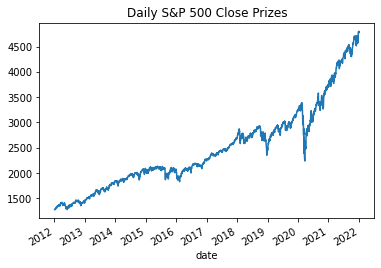

In [29]:
df.close.plot(title="Daily S&P 500 Close Prizes")

In [30]:
df['return'] = df.close - df.open

<AxesSubplot:title={'center':'Daily S&P 500 Return'}, xlabel='date'>

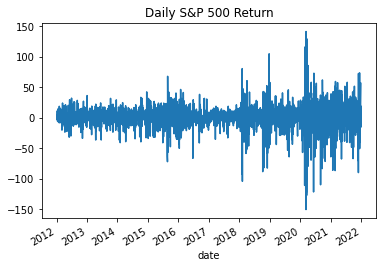

In [31]:
df['return'].plot(title="Daily S&P 500 Return")

### Outliers

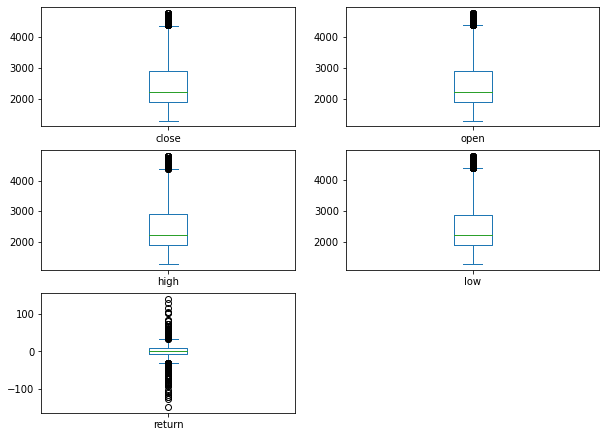

In [32]:
_ = df.plot(kind='box', subplots=True, layout=(7, 2), figsize=(10, 18), sharex=False)

### Correlation Analysis

<AxesSubplot:>

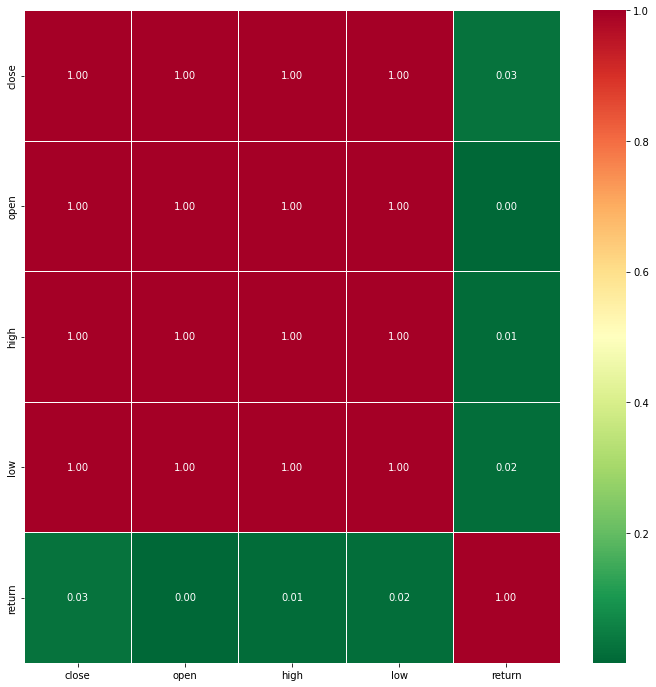

In [33]:
plt.subplots(figsize=(12,12))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn_r', linewidth=0.5, fmt='.2f')

## Data Preprocessing

In [34]:
df['volatility'] = df.high - df.low

<AxesSubplot:title={'center':'Daily S&P 500 Volatility'}, xlabel='date'>

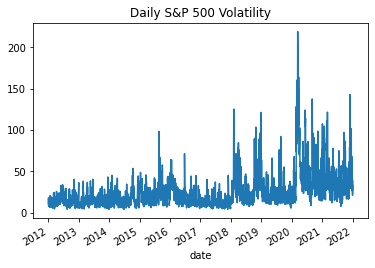

In [35]:
df.volatility.plot(title="Daily S&P 500 Volatility")

### Scaling
We compute the exponentially weighted moving average of every feature (columns). Then, we scale the feature by subtracting the exponentially weighted moving average and dividing by the exponentially weighted standard deviation.

In [36]:
ewdf = df.ewm(halflife=10).mean()

<AxesSubplot:xlabel='date'>

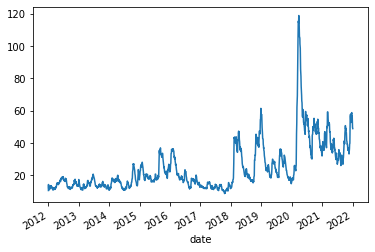

In [37]:
ewdf.volatility.plot()

In [38]:
vewdf = df.ewm(halflife=10).var()

<AxesSubplot:xlabel='date'>

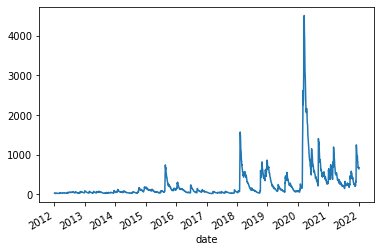

In [39]:
vewdf.volatility.plot()

In [40]:
scaled = df.volatility - ewdf.volatility
scaled = scaled / vewdf.volatility**0.5

<AxesSubplot:xlabel='date'>

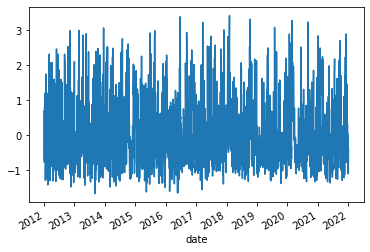

In [41]:
scaled.plot()

In [42]:
df['scaledVolatility'] = ((df['volatility'] - ewdf['volatility'] ) / vewdf['volatility']**0.5)
df['scaledReturn'] = ((df['return'] - ewdf['return']) / vewdf['return']**0.5)

In [43]:
# Drop NA values that come from the exponential smooting
df = df.dropna()

### Splitting to training and test data

In [48]:
num_datapoints = df.shape[0]
num_training = int(num_datapoints*0.7)

In [50]:
train_df = df[:num_training]
test_df = df[num_training:]

In [51]:
selected_features = ['scaledVolatility', 'scaledReturn']
train = train_df.loc[:, selected_features].values
test = test_df.loc[:, selected_features].values

In [52]:
# Verify the shapes of X_train and y_train
print(train.shape)
print(test.shape)

(1787, 2)
(766, 2)


### Transform data into sequences

In [53]:
# Function to transform data into sequences
def transform_to_sequences(data, n_in=1, n_out=1, dropnan=True):
	# n_vars corresponds to the number of features
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	
	# input sequence (t-n, ..., t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
		
	# forecast sequence(t, t+1, ..., t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
		
	# put all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	
	if dropnan:
		# drop all rows that contains Nan values (1st row)
		agg.dropna(inplace=True)
	return agg

In [54]:
# Create sequences
train_transformed = transform_to_sequences(train, 30, 1)
test_transformed = transform_to_sequences(test, 30, 1)

In [55]:
# Verify the shapes of train_transformed and test_transformed
print(train_transformed.shape)
print(test_transformed.shape)

(1757, 62)
(736, 62)


In [56]:
# Split data in input X and output y
n_input_timestamps = 30
n_features_per_timestamp = 2
n_input_features = n_input_timestamps * n_features_per_timestamp

In [57]:
X_train, y_train = train_transformed.values[:, :n_input_features], train_transformed.values[:, n_input_features:]
print(X_train.shape)
print(y_train.shape)

(1757, 60)
(1757, 2)


In [61]:
# Drop first column (= scaledVolatility) as we just want to predict the scaledReturn
y_train = y_train[:, -1]

In [58]:
X_test, y_test = test_transformed.values[:, :n_input_features], test_transformed.values[:, n_input_features:]
print(X_test.shape)
print(y_test.shape)

(736, 60)
(736, 2)


In [62]:
# Drop first column (= scaledVolatility) as we just want to predict the scaledReturn
y_test = y_test[:, -1]

### Reshaping (to fit into the network)

In [63]:
# Reshape data to fit into the LSTM model (dimension must be [samples, time steps, features])
X_train_lstm = X_train.reshape((X_train.shape[0], n_input_timestamps, n_features_per_timestamp))
y_train_lstm = y_train.reshape((y_train.shape[0], 1))

In [65]:
X_test_lstm = X_test.reshape((X_test.shape[0], n_input_timestamps, n_features_per_timestamp))
y_test_lstm = y_test.reshape((y_test.shape[0], 1))

## Implementing Models

### Recurrent Neural Network

In [72]:
def create_rnn_model(n_neurons, optimizer):
    model = Sequential()
    model.add(SimpleRNN(units=n_neurons))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer=optimizer)

    return model

In [77]:
def create_gru_model(n_neurons, optimizer):
    model = Sequential()
    model.add(GRU(units=n_neurons))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer=optimizer)

    return model

### LSTM Network

In [84]:
def create_lstm_model(n_neurons, optimizer):
    model = Sequential()
    model.add(LSTM(units=n_neurons, recurrent_dropout=0.2, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer=optimizer)

    return model

## Train the models

### Recurrent Neural Network

In [74]:
model_rnn = create_rnn_model(100, 'adam')
history_rnn = model_rnn.fit(X_train_lstm, y_train_lstm, epochs=300, batch_size=64, shuffle=False)

Epoch 1/300
28/28 [==============================] - 1s 6ms/step - loss: 0.8886
Epoch 2/300
28/28 [==============================] - 0s 5ms/step - loss: 0.8244
Epoch 3/300
28/28 [==============================] - 0s 5ms/step - loss: 0.8002
Epoch 4/300
28/28 [==============================] - 0s 5ms/step - loss: 0.7825
Epoch 5/300
28/28 [==============================] - 0s 5ms/step - loss: 0.7699
Epoch 6/300
28/28 [==============================] - 0s 6ms/step - loss: 0.7553
Epoch 7/300
28/28 [==============================] - 0s 6ms/step - loss: 0.7369
Epoch 8/300
28/28 [==============================] - 0s 5ms/step - loss: 0.7132
Epoch 9/300
28/28 [==============================] - 0s 5ms/step - loss: 0.6827
Epoch 10/300
28/28 [==============================] - 0s 5ms/step - loss: 0.6449
Epoch 11/300
28/28 [==============================] - 0s 5ms/step - loss: 0.6008
Epoch 12/300
28/28 [==============================] - 0s 6ms/step - loss: 0.5573
Epoch 13/300
28/28 [=================

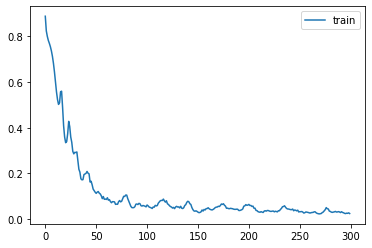

In [75]:
# Plot history
pyplot.plot(history_rnn.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [79]:
model_gru = create_gru_model(100, 'adam')
history_gru = model_gru.fit(X_train_lstm, y_train_lstm, epochs=300, batch_size=64, shuffle=False)

Epoch 1/300
28/28 [==============================] - 2s 12ms/step - loss: 0.8260
Epoch 2/300
28/28 [==============================] - 0s 12ms/step - loss: 0.8239
Epoch 3/300
28/28 [==============================] - 0s 12ms/step - loss: 0.8193
Epoch 4/300
28/28 [==============================] - 0s 12ms/step - loss: 0.8175
Epoch 5/300
28/28 [==============================] - 0s 14ms/step - loss: 0.8167
Epoch 6/300
28/28 [==============================] - 0s 14ms/step - loss: 0.8154
Epoch 7/300
28/28 [==============================] - 0s 13ms/step - loss: 0.8141
Epoch 8/300
28/28 [==============================] - 0s 14ms/step - loss: 0.8129
Epoch 9/300
28/28 [==============================] - 0s 14ms/step - loss: 0.8118
Epoch 10/300
28/28 [==============================] - 0s 14ms/step - loss: 0.8105
Epoch 11/300
28/28 [==============================] - 0s 14ms/step - loss: 0.8093
Epoch 12/300
28/28 [==============================] - 0s 15ms/step - loss: 0.8080
Epoch 13/300
28/28 [=====

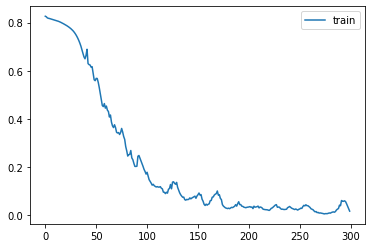

In [80]:
# Plot history
pyplot.plot(history_gru.history['loss'], label='train')
pyplot.legend()
pyplot.show()

### LSTM Network

In [85]:
model_lstm = create_lstm_model(100, 'adam')
history_lstm = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=300, batch_size=64, shuffle=False)

Epoch 1/300
28/28 [==============================] - 2s 24ms/step - loss: 0.8227
Epoch 2/300
28/28 [==============================] - 1s 23ms/step - loss: 0.8223
Epoch 3/300
28/28 [==============================] - 1s 23ms/step - loss: 0.8178
Epoch 4/300
28/28 [==============================] - 1s 24ms/step - loss: 0.8159
Epoch 5/300
28/28 [==============================] - 1s 24ms/step - loss: 0.8165
Epoch 6/300
28/28 [==============================] - 1s 24ms/step - loss: 0.8153
Epoch 7/300
28/28 [==============================] - 1s 23ms/step - loss: 0.8135
Epoch 8/300
28/28 [==============================] - 1s 23ms/step - loss: 0.8136
Epoch 9/300
28/28 [==============================] - 1s 24ms/step - loss: 0.8103
Epoch 10/300
28/28 [==============================] - 1s 24ms/step - loss: 0.8105
Epoch 11/300
28/28 [==============================] - 1s 25ms/step - loss: 0.8075
Epoch 12/300
28/28 [==============================] - 1s 22ms/step - loss: 0.8069
Epoch 13/300
28/28 [=====

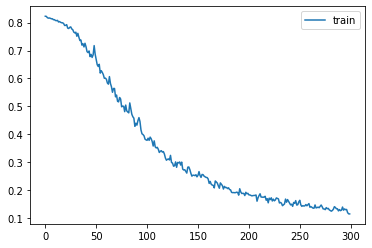

In [86]:
# Plot history
pyplot.plot(history_lstm.history['loss'], label='train')
pyplot.legend()
pyplot.show()